In [305]:
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

import pandas as pd
import numpy as np
import cv2 as cv

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import os
from collections import Counter
import warnings


In [306]:
warnings.filterwarnings('ignore')

---

In [ ]:
def load_images(path, HSV=False):
    images = []
    for file in os.listdir(path):
        if file.lower().endswith('.jpg'):
            img_path = os.path.join(path, file)
            img_bgr = cv.imread(img_path)
            if img_bgr is None:
                continue
            if HSV:  
                img = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)
            else:
                img = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
            images.append(img)
    return np.array(images)

In [364]:
data = load_images('data/$learning_2', HSV=True)

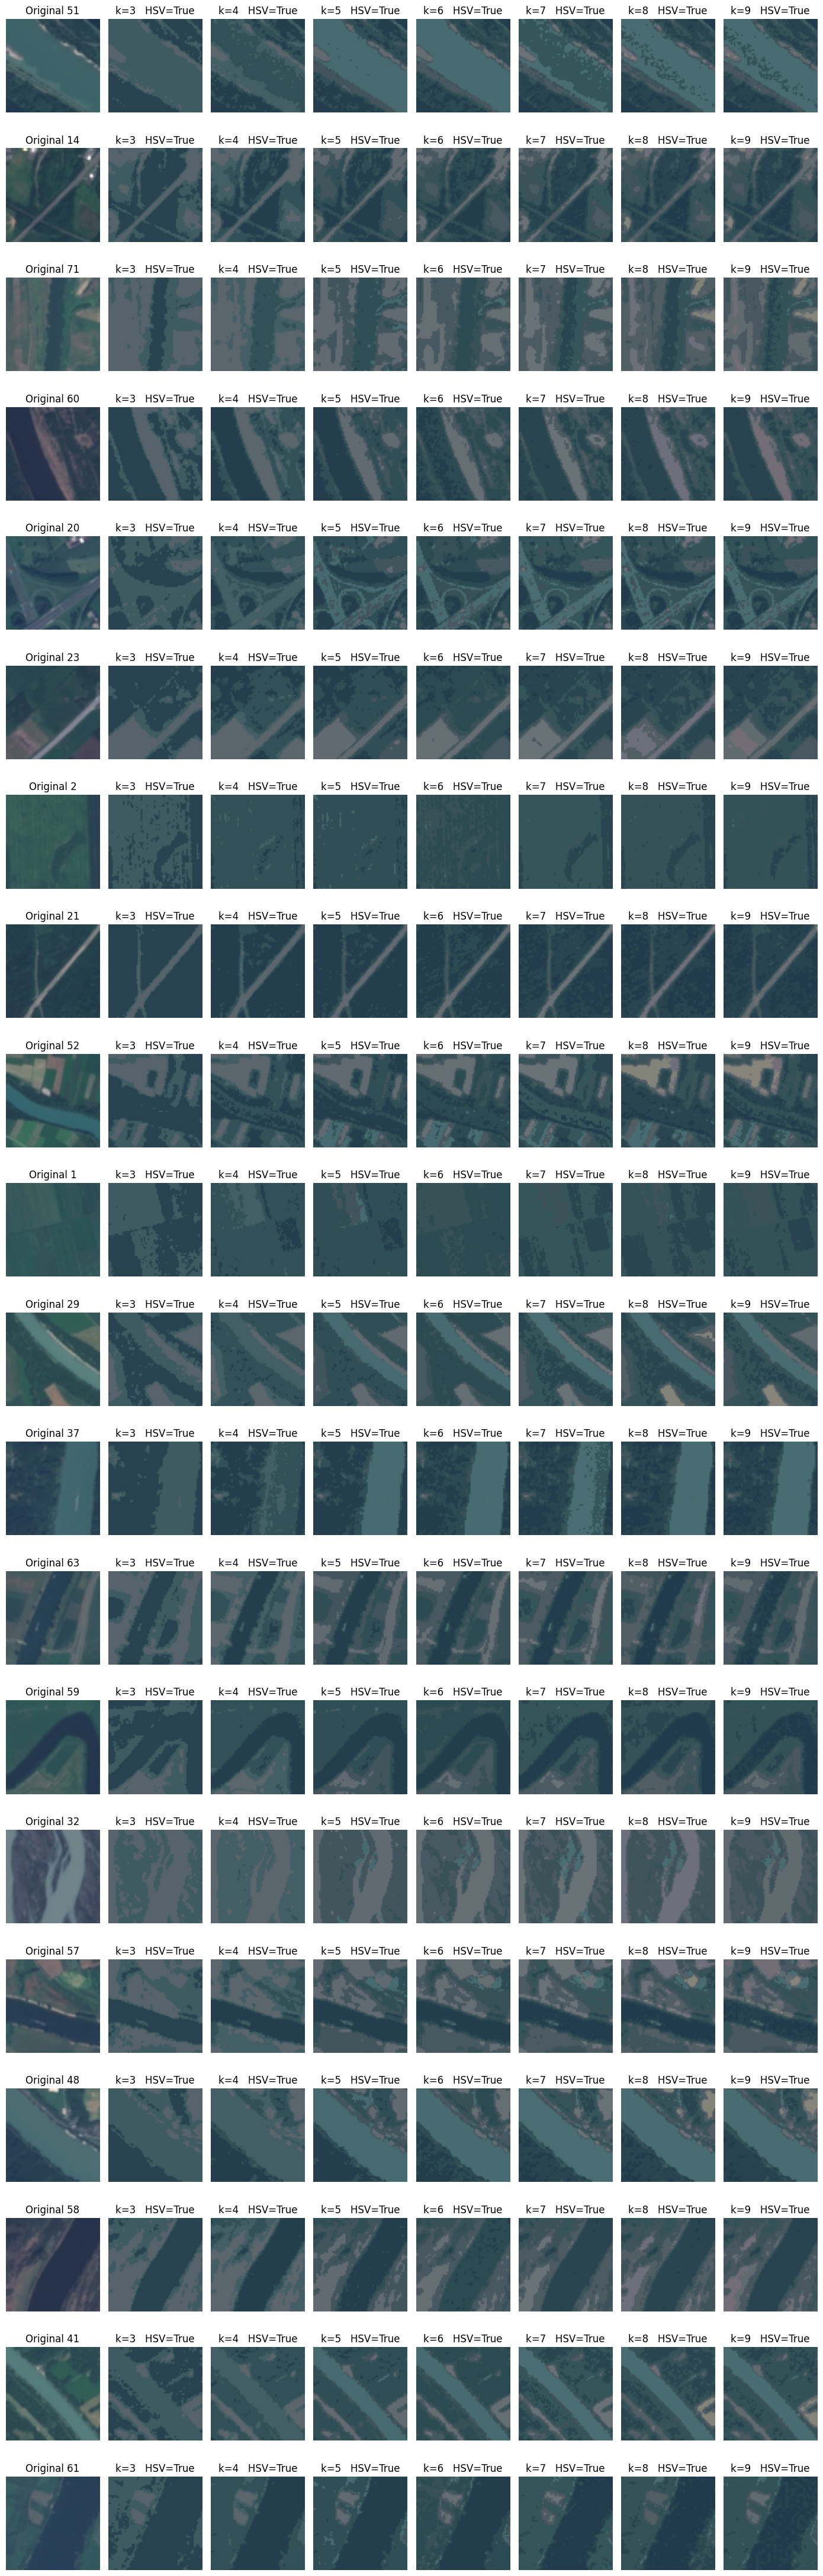

In [367]:
np.random.seed(42)

all_pixels = data.reshape(-1, 3)

reps = 20
k_values = range(3, 10)
kmeans_models = {k: KMeans(n_clusters=k, random_state=42).fit(all_pixels) for k in k_values}

dist_x = int((len(kmeans_models) + 1) * 1.8)
dist_y = int(reps * 2.2)

fig, ax = plt.subplots(reps, len(kmeans_models) + 1, figsize=(dist_x, dist_y), dpi=100)

HSV = True
used = list()
for i in range(reps):
    
    num = np.random.randint(0, len(data))
    while num in used:
        num = np.random.randint(0, len(data))
    used.append(num)

    im = data[num]
    
    if HSV:
        im = cv.cvtColor(im, cv.COLOR_HSV2BGR)
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        
    ax[i, 0].imshow(im)
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f'Original {num}')

    pixels = data[num].reshape(-1, 3)

    for idx, k in enumerate(k_values, start=1):
        model = kmeans_models[k]
        labels = model.predict(pixels)
        segmented_img = model.cluster_centers_[labels]
        segmented_img = segmented_img.reshape(data[num].shape)
        segmented_img = np.clip(segmented_img, 0, 255).astype(np.uint8)
        
        if HSV:
            segmented_img = cv.cvtColor(segmented_img, cv.COLOR_HSV2BGR)
            segmented_img = cv.cvtColor(segmented_img, cv.COLOR_BGR2RGB)

        ax[i, idx].imshow(segmented_img)
        ax[i, idx].axis('off')
        ax[i, idx].set_title(f'{k=}   {HSV=}')

plt.tight_layout()

In [ ]:
def Kmeans_analysis(image_num=None, HSV=False, k=4):
    
    if image_num is None:
        image_num = np.random.randint(len(data))
    
    fig, ax = plt.subplots(1, 3, figsize=(6,2))
    
    im = data[image_num]
    if HSV:
        im = cv.cvtColor(im, cv.COLOR_HSV2BGR)
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    ax[0].imshow(im)
    ax[0].axis('off')
    ax[0].set_title(f'Original {image_num}')
    
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(data.reshape(-1, 3))
    
    pixels = data[image_num].reshape(-1, 3)
    labels = model.predict(pixels)
    
    segmented_img = model.cluster_centers_[labels]
    segmented_img = segmented_img.reshape(data[num].shape)
    segmented_img = np.clip(segmented_img, 0, 255).astype(np.uint8)
    
    if HSV:
        segmented_img = cv.cvtColor(segmented_img, cv.COLOR_HSV2BGR)
        segmented_img = cv.cvtColor(segmented_img, cv.COLOR_BGR2RGB)
    ax[1].imshow(segmented_img)
    ax[1].axis('off')
    ax[1].set_title(f'{HSV=}  {k=}')
    
    cluster_colors = model.cluster_centers_

    if HSV:
        cluster_colors = cluster_colors.astype(np.uint8).reshape(-1,1,3)
        cluster_colors_rgb = cv.cvtColor(cluster_colors, cv.COLOR_HSV2RGB).reshape(-1,3)
    else:
        cluster_colors_rgb = cluster_colors

    if cluster_colors_rgb.max() <= 1.0:
        cluster_colors_rgb = (cluster_colors_rgb * 255).astype(np.uint8)
    else:
        cluster_colors_rgb = cluster_colors_rgb.astype(np.uint8)

    hex_colors = [mcolors.to_hex(c / 255) for c in cluster_colors_rgb]
    palette = {str(i): hex_colors[i] for i in range(len(hex_colors))}
    labels_str = labels.astype(str)

    sns.countplot(x=labels_str, palette=palette, ax=ax[2])
    
    ax[2].set_title('Clusters size')
    ax[2].set_ylabel('')
    ax[2].tick_params(axis='y', labelsize=8)  
    box = ax[2].get_position()
    ax[2].set_position([box.x0, box.y0 + 0.047, box.width, box.height * 0.88]) 
    ticks = ax[2].get_yticks()
    ax[2].yaxis.tick_right()
    ax[2].set_yticks([ticks[-1]])
    ax[2].set_yticklabels([f'{int(ticks[-1])}'], fontsize=10)
    

presentable images: 12, 14
best configs: HSV + 5, 7; no HSV + 4

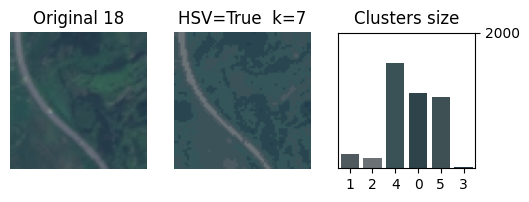

In [361]:
data = load_images('data/$learning_2', HSV=True)
Kmeans_analysis(image_num=18, HSV=True, k=7)

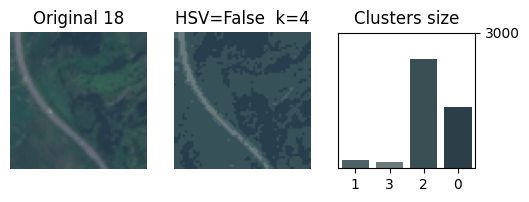

In [362]:
data = load_images('data/$learning_2', HSV=False)
Kmeans_analysis(image_num=18, HSV=False, k=4)